In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/oregon_wildlife.zip" -d "/content"

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random

In [5]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/black_bear
oregon_wildlife/virginia_opossum
oregon_wildlife/cougar
oregon_wildlife/red_fox
oregon_wildlife/sea_lions
oregon_wildlife/raccoon
oregon_wildlife/nutria
oregon_wildlife/deer
oregon_wildlife/bald_eagle
oregon_wildlife/raven

total img num: 7168


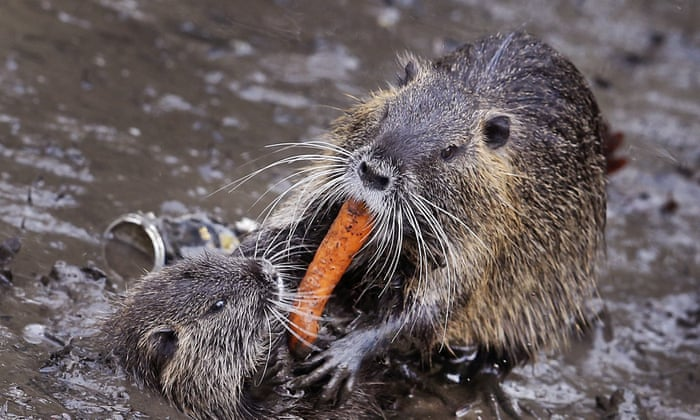

nutria


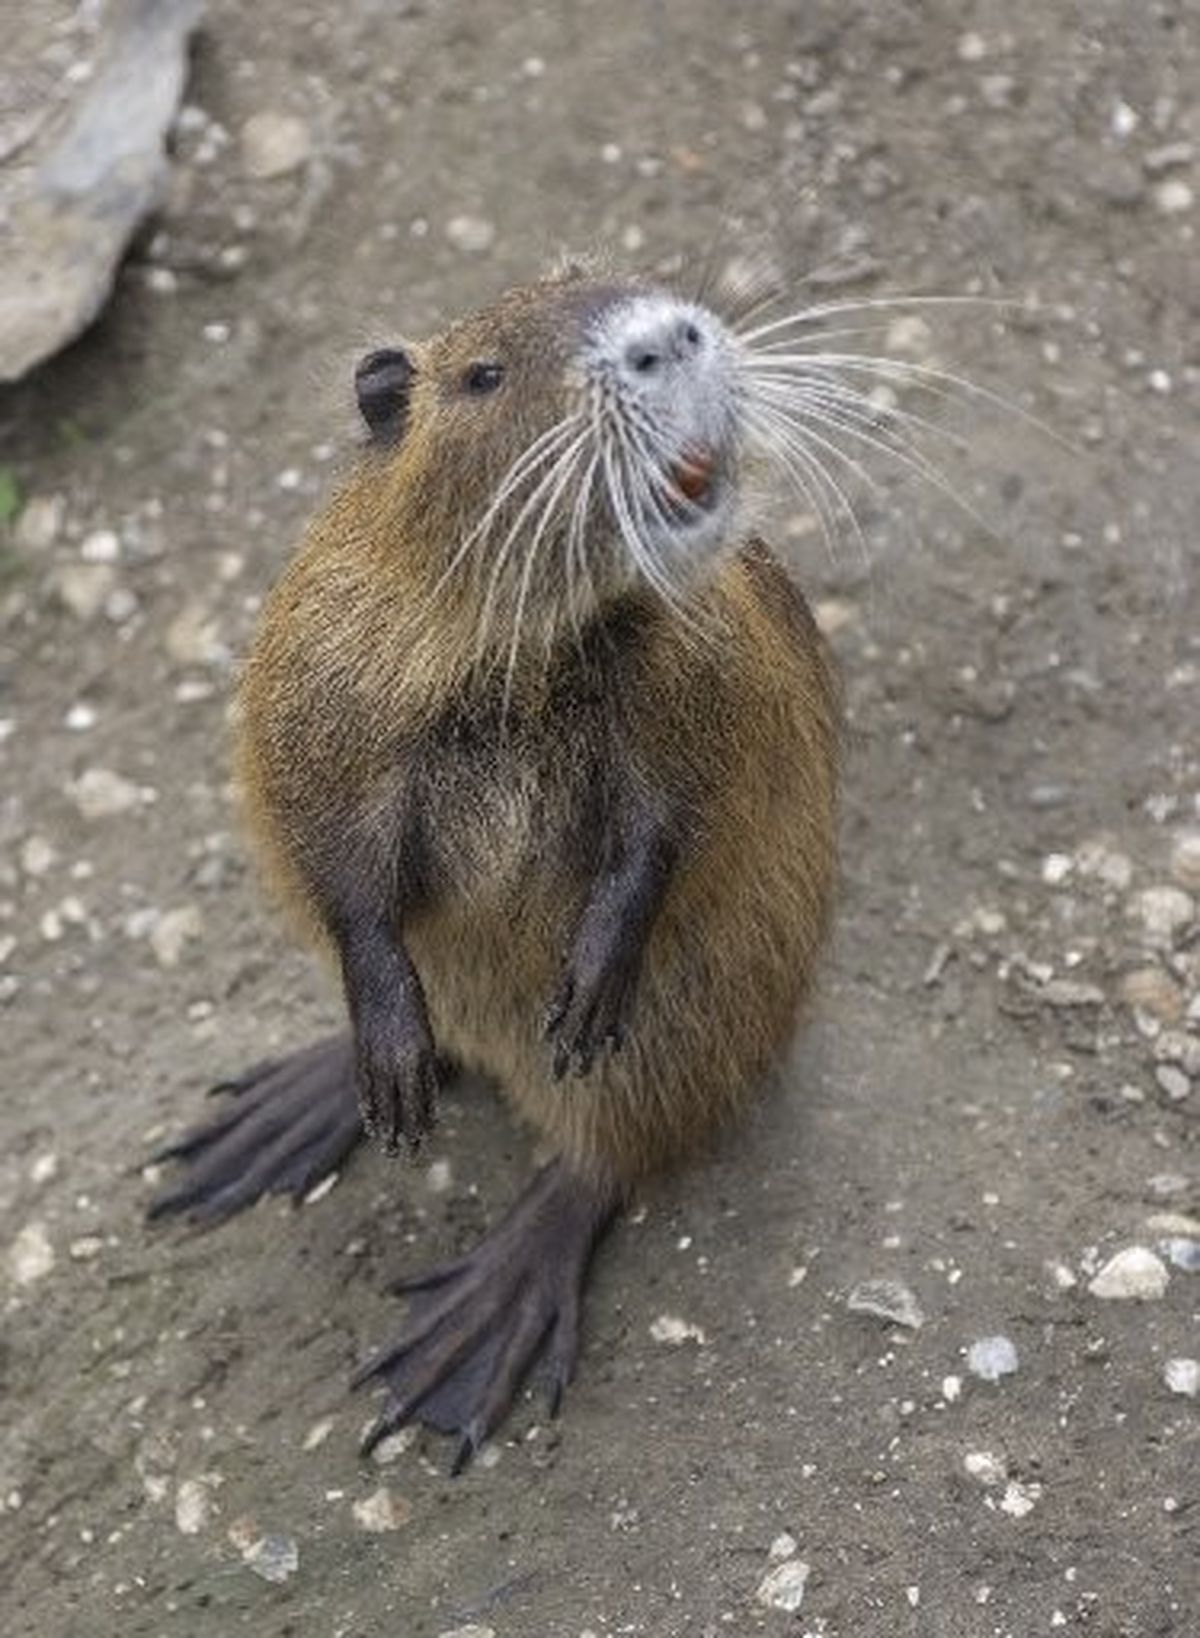

nutria


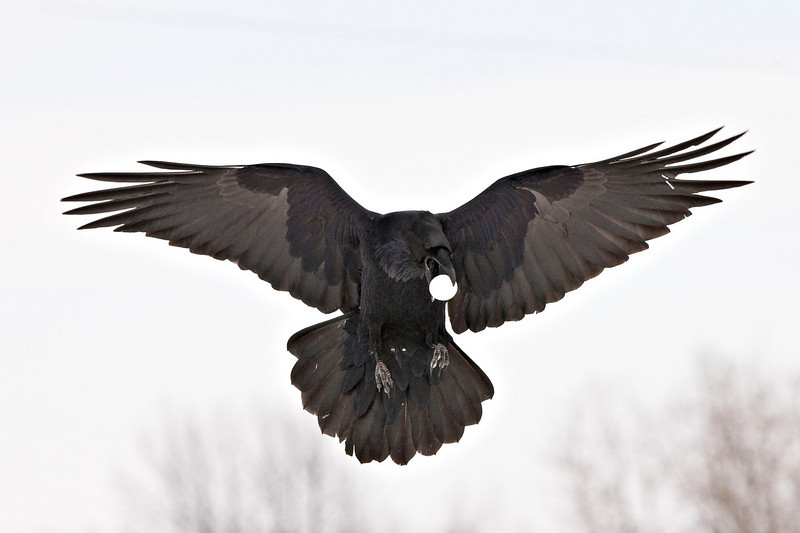

raven


In [6]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [7]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [8]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [9]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 5, 2, 5, 9, 2, 9, 1, 9, 1]


In [10]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [0]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [0]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [0]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

In [0]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int32_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def serialize_example(img, label):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        #'img': _float_feature(img.numpy().ravel()),
        'img': _bytes_feature(img.numpy().tostring()),
        'label': _int32_feature(label.numpy()),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [0]:
def tf_serialize_example(img,label):
    tf_string = tf.py_function(
        serialize_example,
        (img,label),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

    # todo1:
        # write the dataset above to tfrecord

In [0]:
dataset_t = dataset_train.map(tf_serialize_example)
filename_t = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename_t)
writer.write(dataset_t)

dataset_v = dataset_val.map(tf_serialize_example)
filename_v = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename_v)
writer.write(dataset_v)

In [18]:
filenames = ['training.tfrecord']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [0]:
# Create a description of the features.
import numpy as np

feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  features = tf.io.parse_single_example(example_proto, feature_description)
  image = tf.io.decode_raw(features['img'], tf.float32)
  image = tf.reshape(image, [300, 300, 3]) 
  label = features['label']
  return [image, label]

In [0]:
    # todo2:
        # read the data from tfrecord you get in Todo1

In [21]:
dataset_train = raw_dataset.map(_parse_function)
dataset_train

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>

In [22]:
filenames = ['testing.tfrecord']
raw_dataset = tf.data.TFRecordDataset(filenames)
dataset_valid = raw_dataset.map(_parse_function)
dataset_valid

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>

(300, 300, 3)


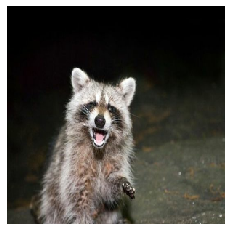

raccoon


In [23]:
# show one image here.
for data in dataset_train.take(1):
    img = data[0]
    label = data[1]
    print(img.shape)
    plt.imshow(img) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

In [0]:
def map_fun(image,label):
    label = label
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    label = label
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [0]:
    # todo3:
        # remember to preprocess the data. You can refer to the code in the Cifar10 section.

In [26]:
dataset_train = dataset_train.map(map_fun)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE)


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
dataset_valid = dataset_valid.map(map_fun_test)
dataset_valid = dataset_valid.shuffle(BUFFER_SIZE)
dataset_valid = dataset_valid.batch(BATCH_SIZE)

In [28]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

58892288/58889256 [==============================] - 2s 0us/step


In [29]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train, validation_data=dataset_valid, epochs=5)

Epoch 1/5
180/180 [==============================] - 74s 412ms/step - loss: 2.5918 - accuracy: 0.5656 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
180/180 [==============================] - 66s 369ms/step - loss: 0.7079 - accuracy: 0.7719 - val_loss: 0.2863 - val_accuracy: 0.9059
Epoch 3/5
180/180 [==============================] - 67s 370ms/step - loss: 0.5787 - accuracy: 0.8202 - val_loss: 0.2956 - val_accuracy: 0.9017
Epoch 4/5
180/180 [==============================] - 67s 370ms/step - loss: 0.6004 - accuracy: 0.8282 - val_loss: 0.2695 - val_accuracy: 0.9212
Epoch 5/5
180/180 [==============================] - 67s 370ms/step - loss: 0.4915 - accuracy: 0.8547 - val_loss: 0.2238 - val_accuracy: 0.9365
